# Web Service Classification using DL (BI- LSTM)

## Our goal is to build a baseline model with at least 80% accuracy

## 1. Load Python Modules

In [1]:
import pandas as pd
import numpy as np
import re
import os
import pickle
import warnings

# Text Preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, Bidirectional, Dense, Dropout,GlobalMaxPooling1D,LayerNormalization

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Notebook settings
warnings.filterwarnings("ignore")
sns.set(style="whitegrid")
%matplotlib inline

# Setup directories
os.makedirs("charts", exist_ok=True)
os.makedirs("results", exist_ok=True)

## 2. Generate Report in CSV

In [2]:
def generate_report_csv(report_dict, confusion_mat, class_labels, output_file="DL-Report.csv"):
    df = pd.DataFrame(report_dict).transpose()

    # Filter only class label rows
    df = df.loc[[str(cls) for cls in class_labels if str(cls) in df.index]].copy()

    # Compute per-class accuracy
    row_sums = confusion_mat.sum(axis=1)
    diagonal = np.diag(confusion_mat)
    per_class_accuracy = (diagonal / row_sums).round(2)

    df['accuracy'] = per_class_accuracy
    if 'support' in df.columns:
        df = df.drop(columns=['support'])

    df.reset_index(inplace=True)
    df.rename(columns={'index': 'Category'}, inplace=True)

    df.to_csv(f"results/{output_file}", index=False)
    print(f"Classification report saved to: {output_file}")

## 3. Confusion Matrix - Show - Save

In [3]:
def generate_confusion_heatmap(cm, class_names, name):
    n_classes = len(class_names)
    figsize = (18, 18) if n_classes >= 40 else (8, 8)

    plt.figure(figsize=figsize)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, annot_kws={"size": 6})
    plt.title(f'Confusion Matrix: {name}', fontsize=16)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('Actual', fontsize=14)
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)
    plt.tight_layout()
    save_path = f"charts/DL_confusion_matrix_{name.replace(' ', '_')}.png"
    plt.savefig(save_path)
    plt.show()
    print(f"Confusion matrix saved to: {save_path}")

## 4. Evaluate Model

In [4]:
def evaluate_and_report(y_test, y_pred, name, labels, class_names):
    print(f"\n {name} Classification Report:\n")
    print(classification_report(y_test, y_pred,target_names=class_names))

    report = classification_report(y_test, y_pred, output_dict=True, labels=labels)
    cm = confusion_matrix(y_test, y_pred, labels=labels)

    generate_report_csv(report, cm, class_labels=labels, output_file=f"DL-Report-{name}.csv")
    generate_confusion_heatmap(cm, class_names, name)

    return {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='weighted', zero_division=0),
        "recall": recall_score(y_test, y_pred, average='weighted', zero_division=0),
        "f1_score": f1_score(y_test, y_pred, average='weighted', zero_division=0)
    }

## 5. Build - Model

In [5]:

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')
# Initialize tools
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in stemmed_tokens]

    return " ".join(lemmatized_tokens)


def build_dl_model(input_length, num_classes, model_type="rnn"):
    model = Sequential()
    # Embedding Layer 
    model.add(Embedding(input_dim=10000, output_dim=128, input_length=input_length))
    # 1st BiLSTM with reduced units
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.3))
    # Replacing 2nd BiLSTM with GlobalMaxPooling 
    model.add(LayerNormalization())
    model.add(GlobalMaxPooling1D())
    # Dense Layers (smaller size and stronger dropout)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    # Compile
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\91956\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


## 6. Train the Model 

In [6]:

def train_dl_model(df, model_type, name, max_len=150):
    df = df.dropna(subset=["Service Description", "Service Classification"])
    df["Service Description"] = df["Service Description"].apply(clean_text)

    texts = df['Service Description'].values
    labels = df['Grouped Category'].values

    tokenizer = Tokenizer(num_words=10000)
    tokenizer.fit_on_texts(texts)
    X_seq = tokenizer.texts_to_sequences(texts)
    X_pad = pad_sequences(X_seq, maxlen=max_len, padding='post')

    le = LabelEncoder()
    y_enc = le.fit_transform(labels)
    y_cat = to_categorical(y_enc)
    num_classes = y_cat.shape[1]

    X_train, X_test, y_train, y_test = train_test_split(X_pad, y_cat, test_size=0.2, random_state=42, stratify=y_cat)

    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_enc), y=y_enc)
    class_weights = dict(enumerate(class_weights))

    model = build_dl_model(input_length=max_len, num_classes=num_classes, model_type=model_type)

    # Train and capture history
    history = model.fit(
        X_train, y_train,
        epochs=30,
        batch_size=32,
        validation_split=0.2,
        class_weight=class_weights,
        verbose=1
    )

    # Plotting training history
    plt.figure(figsize=(14, 6))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    plt.tight_layout()
    plt.show()

    y_pred = np.argmax(model.predict(X_test), axis=1)
    y_true = np.argmax(y_test, axis=1)  # Fix: convert from one-hot to labels

    labels = le.inverse_transform(np.arange(num_classes))  # class names (strings)

    # Fix: use y_true (not y_test anymore)
    result = evaluate_and_report(y_true, y_pred, name, np.arange(num_classes), labels)
    result["model"] = "BI-LSTM"
    return result


## 6. Models


Processing Top 45 Web Service Categories



Epoch 1/30


180/180 [==============================] - 15s 65ms/step - loss: 3.6233 - accuracy: 0.0730 - val_loss: 3.0917 - val_accuracy: 0.3433
Epoch 2/30
180/180 [==============================] - 11s 61ms/step - loss: 2.5405 - accuracy: 0.3209 - val_loss: 1.8497 - val_accuracy: 0.6421
Epoch 3/30
180/180 [==============================] - 11s 62ms/step - loss: 1.5488 - accuracy: 0.5777 - val_loss: 1.2449 - val_accuracy: 0.7345
Epoch 4/30
180/180 [==============================] - 12s 66ms/step - loss: 0.9416 - accuracy: 0.7318 - val_loss: 0.9732 - val_accuracy: 0.7707
Epoch 5/30
180/180 [==============================] - 11s 62ms/step - loss: 0.6364 - accuracy: 0.8164 - val_loss: 0.8896 - val_accuracy: 0.7839
Epoch 6/30
180/180 [==============================] - 12s 64ms/step - loss: 0.4323 - accuracy: 0.8733 - val_loss: 0.8518 - val_accuracy: 0.7922
Epoch 7/30
180/180 [==============================] - 11s 63ms/step - loss: 0.3385 - accu

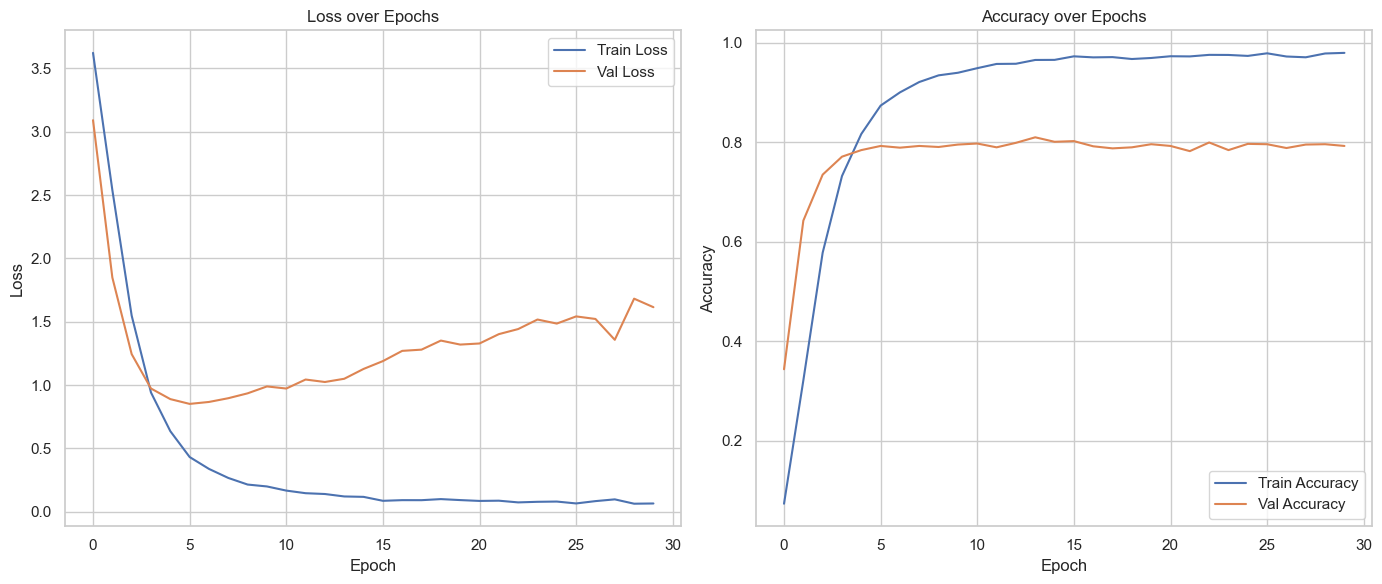

57/57 [==============================] - 1s 14ms/step

 BI-LSTM Top 45 Classification Report:

                         precision    recall  f1-score   support

            Advertising       0.72      0.57      0.64        40
              Analytics       0.86      0.80      0.83        40
Application Development       0.74      0.70      0.72        40
                Backend       0.76      0.72      0.74        40
                Banking       0.98      1.00      0.99        40
                Bitcoin       0.95      0.97      0.96        40
                   Chat       0.95      0.97      0.96        40
                  Cloud       0.73      0.80      0.76        40
                   Data       0.59      0.75      0.66        40
               Database       0.64      0.75      0.69        40
                Domains       0.97      0.93      0.95        40
              Education       0.91      0.75      0.82        40
                  Email       0.76      0.78      0.77     

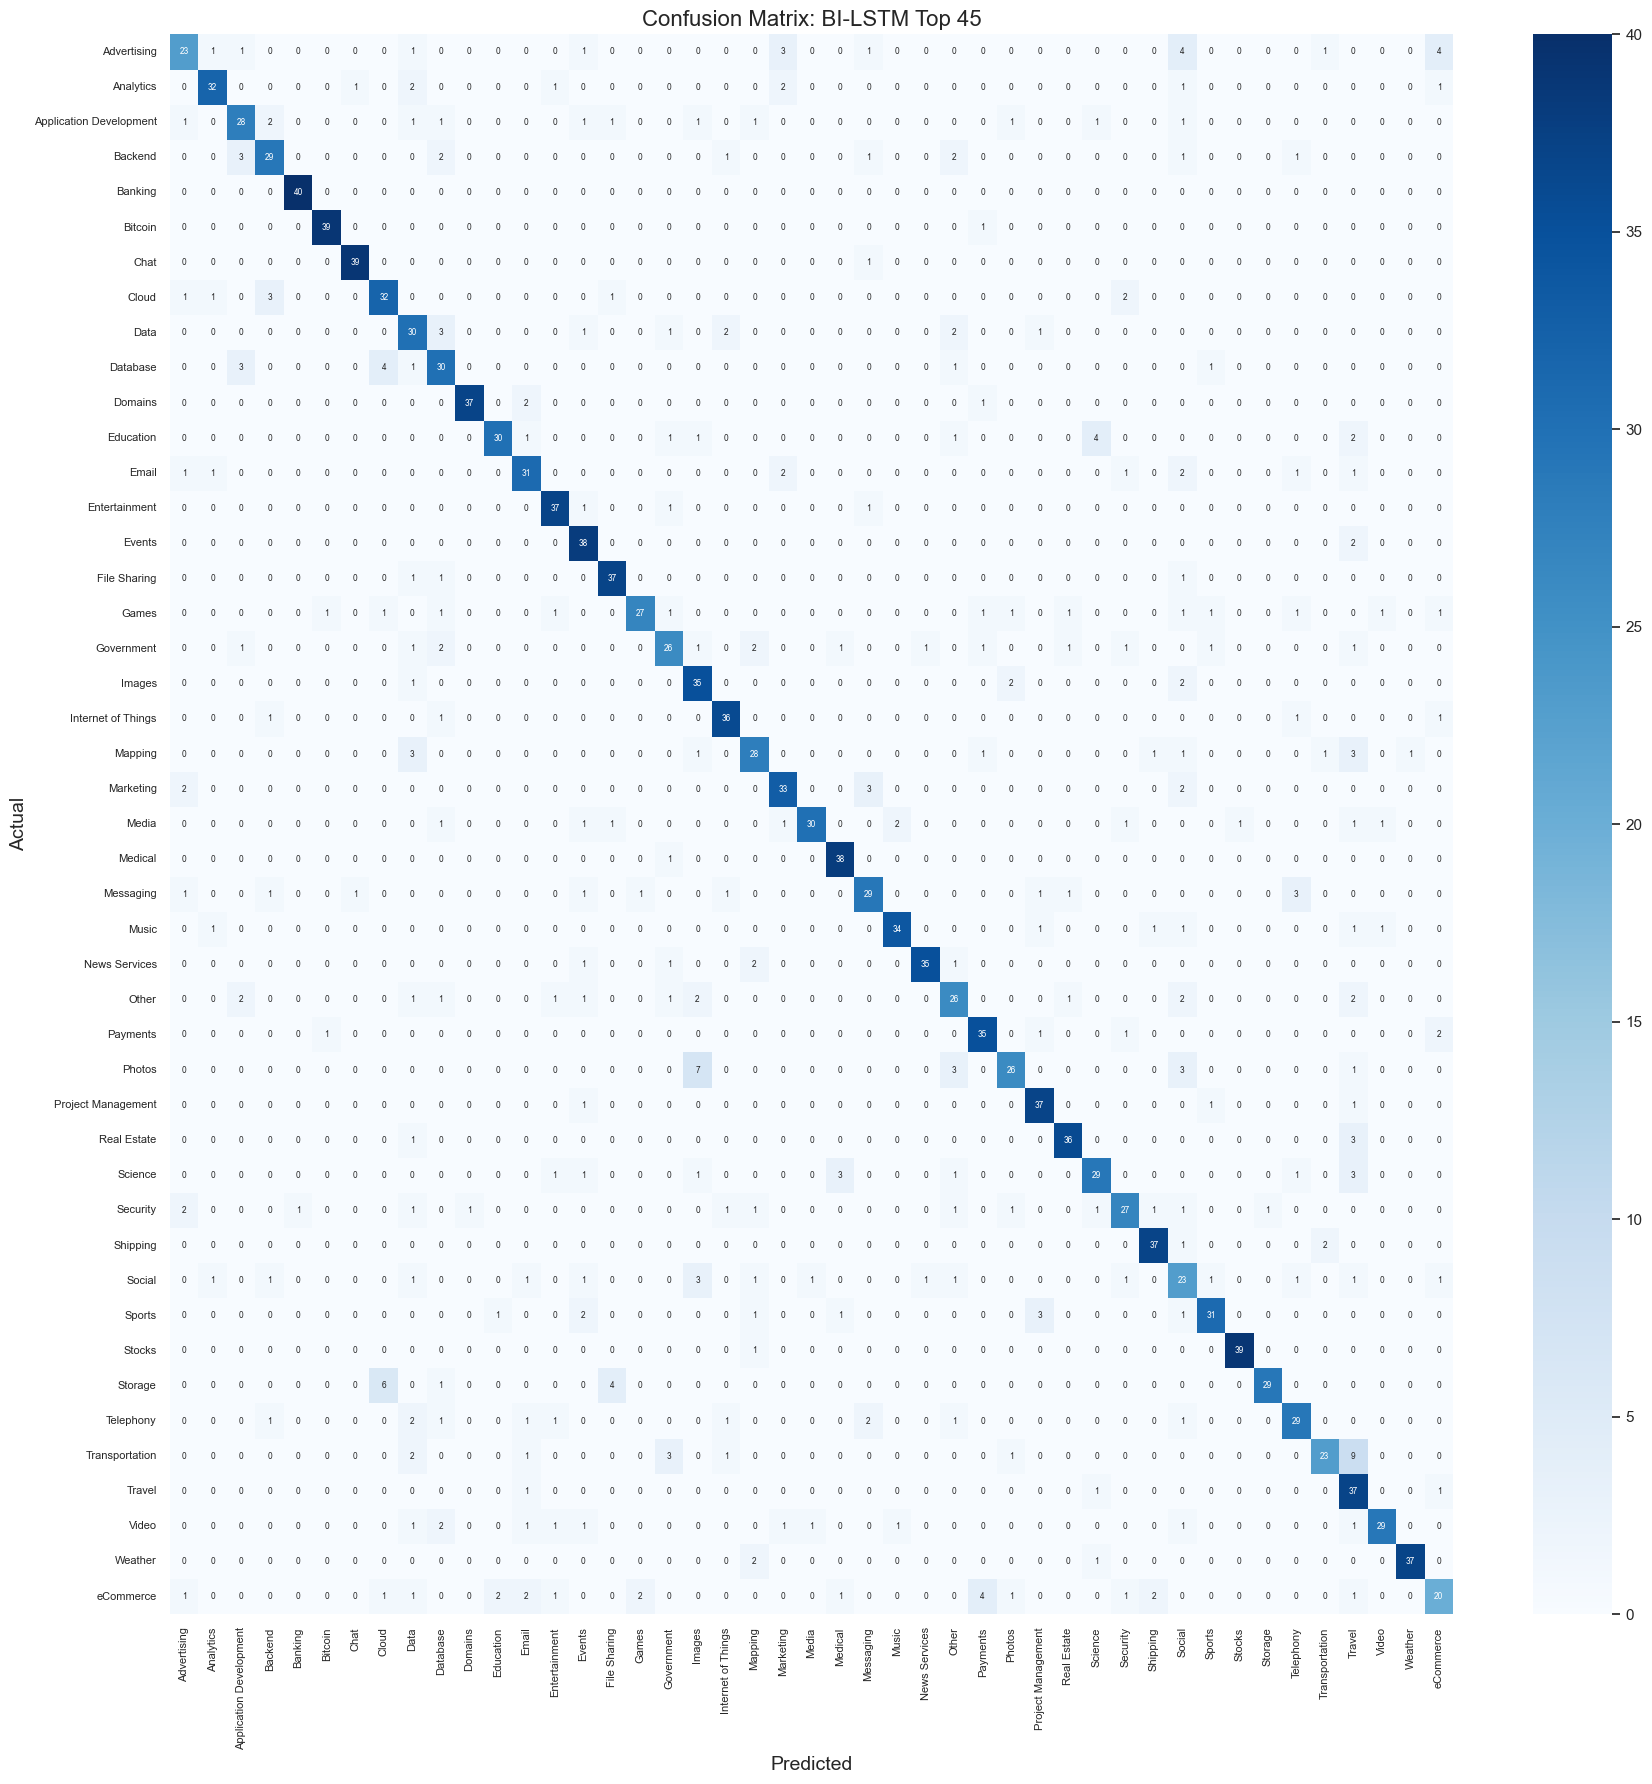

Confusion matrix saved to: charts/DL_confusion_matrix_BI-LSTM_Top_45.png
{'accuracy': 0.7965536409116175, 'precision': 0.808283066412286, 'recall': 0.7965536409116175, 'f1_score': 0.7969553338386383, 'model': 'BI-LSTM'}


In [7]:
if __name__ == "__main__":
    dl_final_results = []

    for n in [45]:
        print(f"\nProcessing Top {n} Web Service Categories")
        input_csv = f"../data/Balanced_Top_{n}_Web_Services.csv"
        df = pd.read_csv(input_csv)
        results = []
        for model_type in ["BI-LSTM"]:
            name = f"{model_type.upper()} Top {n}"
            result = train_dl_model(df, model_type, name)
            dl_final_results.append(result)
            print(result)
        

    # Save all results
    with open("results/dl_final_results.pkl", "wb") as f:
        pickle.dump(dl_final_results, f)

## 5. Performance and Plots

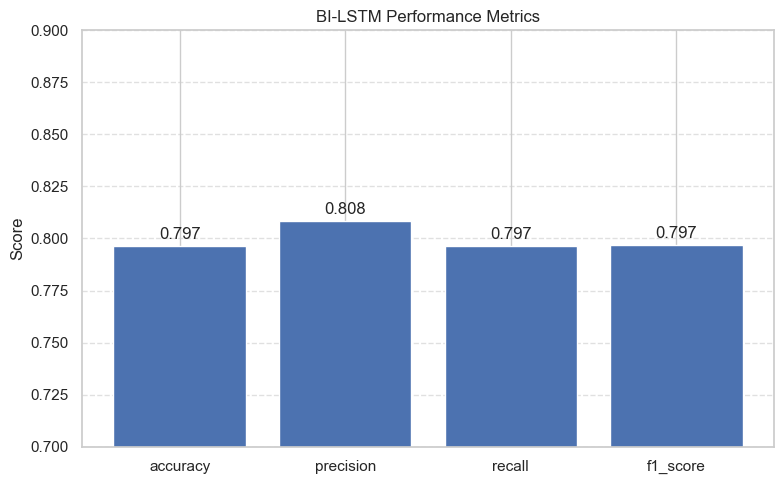

In [8]:

import matplotlib.pyplot as plt

# Plot settings
for metric_dict in dl_final_results:
    model_name = metric_dict['model']
    metrics = {k: v for k, v in metric_dict.items() if k != 'model'}

    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values())
    
    # Labels and title
    plt.ylabel('Score')
    plt.ylim(0.7, 0.9)  # Adjust range as needed
    plt.title(f'{model_name} Performance Metrics')

    # Annotate bar values
    for key, value in metrics.items():
        plt.text(key, value + 0.002, f"{value:.3f}", ha='center', va='bottom')

    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


